In [12]:
import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [13]:
# Load Weather Dataset
df = pd.read_excel('final_verified_weather_data.xlsx')

# Create a new column for date from Year, Month and Date column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Date']].astype(str).agg('-'.join, axis=1))

# Drop the year and month column
df.drop(['Year', 'Month'], axis=1, inplace=True)

# Set Date column as the index
df.set_index('Date', inplace=True)

# Read Power Data
solar_df = pd.read_csv('daily_power_production.csv')

# Set the time column as the index
solar_df['time'] = pd.to_datetime(solar_df['time'])
solar_df.set_index('time', inplace=True)

# Join the weather and the Solar power datasets into one dataset
combined_df = df.join(solar_df, how='inner')

In [14]:
# Define the split date
split_date = '2016-06-30'

# Split the data
train_data = combined_df.loc[combined_df.index <= split_date]
test_data = combined_df.loc[combined_df.index > split_date]

# Split the exogs with the 'Power' columns
train_exogs = train_data.drop('Power', axis=1)
test_exogs = test_data.drop('Power', axis=1)

train_power = train_data['Power']
test_power = test_data['Power']

In [15]:
# Normalize the data
scaler_exogs = MinMaxScaler()
scaler_power = MinMaxScaler()

train_exogs_scaled = scaler_exogs.fit_transform(train_exogs)
test_exogs_scaled = scaler_exogs.transform(test_exogs)

train_power_scaled = scaler_power.fit_transform(train_power.values.reshape(-1, 1))
test_power_scaled = scaler_power.transform(test_power.values.reshape(-1, 1))

# Reshape the data for LSTM
train_exogs_scaled = train_exogs_scaled.reshape((train_exogs_scaled.shape[0], 1, train_exogs_scaled.shape[1]))
test_exogs_scaled = test_exogs_scaled.reshape((test_exogs_scaled.shape[0], 1, test_exogs_scaled.shape[1]))

In [16]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_exogs_scaled.shape[1], train_exogs_scaled.shape[2])),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_exogs_scaled, train_power_scaled, epochs=200, batch_size=32, validation_data=(test_exogs_scaled, test_power_scaled), verbose=2, shuffle=False)

Epoch 1/200
20/20 - 2s - 123ms/step - loss: 0.1209 - val_loss: 0.0360
Epoch 2/200
20/20 - 0s - 12ms/step - loss: 0.0437 - val_loss: 0.0367
Epoch 3/200
20/20 - 0s - 10ms/step - loss: 0.0412 - val_loss: 0.0283
Epoch 4/200
20/20 - 0s - 11ms/step - loss: 0.0354 - val_loss: 0.0253
Epoch 5/200
20/20 - 0s - 11ms/step - loss: 0.0314 - val_loss: 0.0235
Epoch 6/200
20/20 - 0s - 12ms/step - loss: 0.0282 - val_loss: 0.0215
Epoch 7/200
20/20 - 0s - 12ms/step - loss: 0.0255 - val_loss: 0.0199
Epoch 8/200
20/20 - 0s - 10ms/step - loss: 0.0233 - val_loss: 0.0186
Epoch 9/200
20/20 - 0s - 10ms/step - loss: 0.0216 - val_loss: 0.0176
Epoch 10/200
20/20 - 0s - 10ms/step - loss: 0.0203 - val_loss: 0.0168
Epoch 11/200
20/20 - 0s - 10ms/step - loss: 0.0194 - val_loss: 0.0162
Epoch 12/200
20/20 - 0s - 11ms/step - loss: 0.0188 - val_loss: 0.0158
Epoch 13/200
20/20 - 0s - 9ms/step - loss: 0.0183 - val_loss: 0.0155
Epoch 14/200
20/20 - 0s - 10ms/step - loss: 0.0180 - val_loss: 0.0153
Epoch 15/200
20/20 - 0s - 10m

In [17]:

# Make predictions
train_predictions = model.predict(train_exogs_scaled)
test_predictions = model.predict(test_exogs_scaled)

# Inverse transform the predictions
train_predictions = scaler_power.inverse_transform(train_predictions)
test_predictions = scaler_power.inverse_transform(test_predictions)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_power, train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_power, test_predictions))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train RMSE: 598.2813930359513
Test RMSE: 566.5536645485059


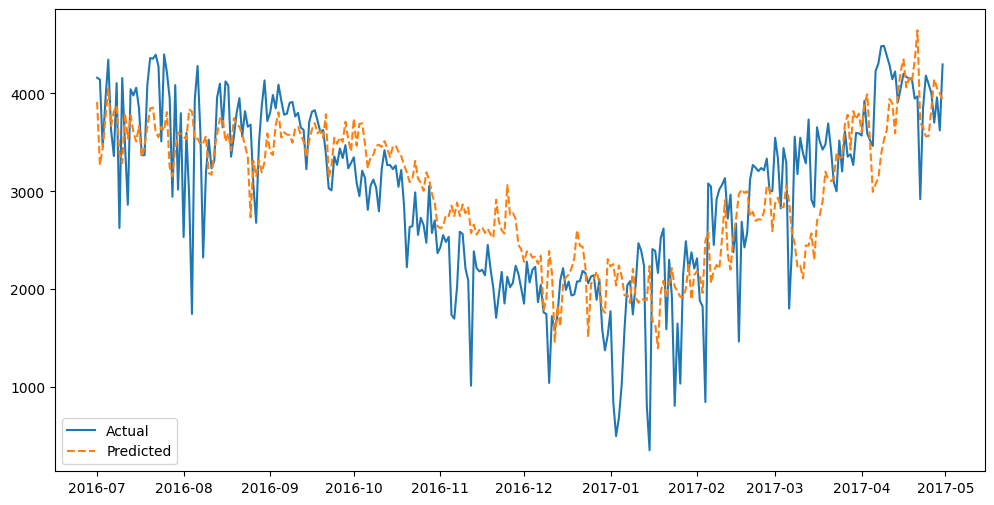

In [18]:
# Create a DataFrame to compare the actual and predicted values
results = pd.DataFrame({'Actual': test_power, 'Predicted': test_predictions.flatten()}, index=test_power.index)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results['Actual'], label='Actual')
plt.plot(results['Predicted'], label='Predicted', linestyle='--')
plt.legend()
plt.show()